In [1]:
import numpy as np
import math
import matplotlib

import matplotlib.pyplot as plt
import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time

from scipy import interpolate
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import cm
from matplotlib.patches import Rectangle, Polygon, Ellipse

In [2]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [3]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


<ipython-input-3-47b328886674>:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


In [4]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [5]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [400, 450, 500, 550, 600, 650]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [7]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [8]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=sig*vns) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities_bse/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=30)

70.69816088676453 s


In [9]:
# Read SSE model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D_SSE = []
NS_KICKS_2D_SSE = []
NS_KICK_MULT_SSE = [] 
SIGMAS_SSE = []

f = IntProgress(min=0, max=sig*vns) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D_SSE.append(v_3d)
        NS_KICKS_2D_SSE.append(v_2d)
        NS_KICK_MULT_SSE.append(ns_kick)
        SIGMAS_SSE.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=30)

60.28912281990051 s


In [51]:
def plot_kde(PLOT_RANGE, NS_KICKS_3D, NS_KICKS_2D, d=3, output=None, lw=3, linestyle='-', alpha=1, label_prefix='', label_suffix=''):    
    for i in PLOT_RANGE:
        kde_NS_3D = gaussian_kde( NS_KICKS_3D[i] )
        kde_NS_2D = gaussian_kde( NS_KICKS_2D[i] )
        NS_dist_space = linspace( min(NS_KICKS_3D[i]), max(NS_KICKS_3D[i]), 300 )
        label_str = label_prefix + r'v$_{ns}$=' + '{nskick}'.format(nskick=NS_KICK_MULT[i]) + ', $\sigma_{ns}$=' + '{sig}'.format(sig=SIGMAS[i]) + label_suffix
        if d==2:
            plt.plot( NS_dist_space, kde_NS_2D(NS_dist_space), linestyle, lw=lw, label=label_str, alpha=alpha);
        else:
            plt.plot( NS_dist_space, kde_NS_3D(NS_dist_space), linestyle, lw=lw, label=label_str, alpha=alpha);

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [(km/s)$^{-1}$]')

    plt.rc('font', size=fm)
    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0), useMathText=True)

    plt.xlim(0, 1200)

    plt.legend(fontsize=fm)
    plt.tight_layout()
    if output is not None:
        plt.savefig(output)


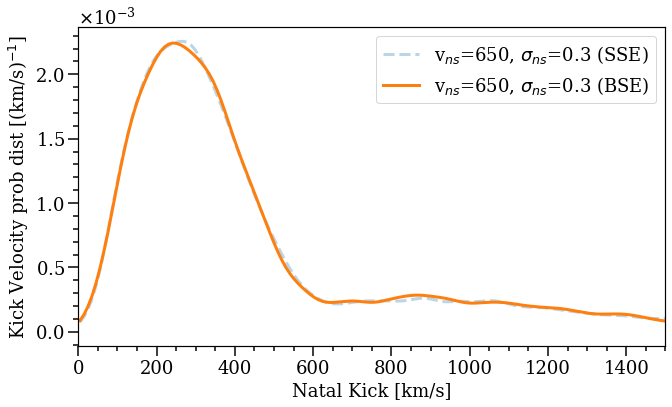

In [52]:
plt.rc('font', size=fm)
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plot_kde(np.intersect1d(kick_models["NS_650_RANGE"], kick_models["SIGMA_0.3_RANGE"]), NS_KICKS_3D_SSE, NS_KICKS_2D_SSE, d=3, linestyle='--', alpha=0.3, label_suffix=' (SSE)')
plot_kde(np.intersect1d(kick_models["NS_650_RANGE"], kick_models["SIGMA_0.3_RANGE"]), NS_KICKS_3D, NS_KICKS_2D, d=3, label_suffix=' (BSE)')
# plot_kde(np.intersect1d(kick_models["NS_550_RANGE"], kick_models["SIGMA_0.4_RANGE"]), NS_KICKS_3D_SSE, NS_KICKS_2D_SSE, d=3, linestyle='--', alpha=0.7, label_suffix=' (SSE)')

plt.xlim(0, 1500)
plt.show()

## Paper Plots

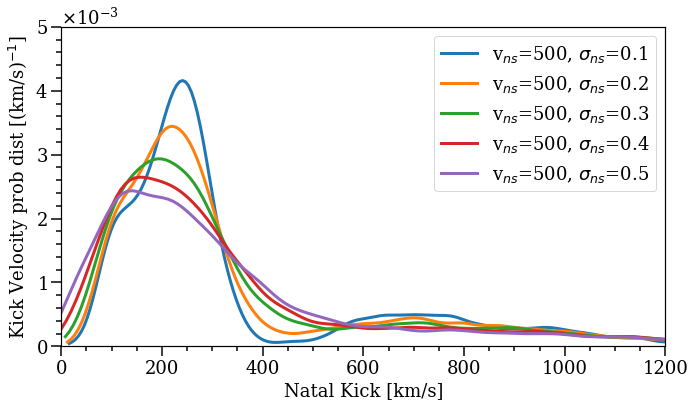

In [53]:
output=None
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
ax.set_ylim(0, 5e-3)
plot_kde(kick_models["NS_500_RANGE"], NS_KICKS_3D, NS_KICKS_2D, output=output, d=3)

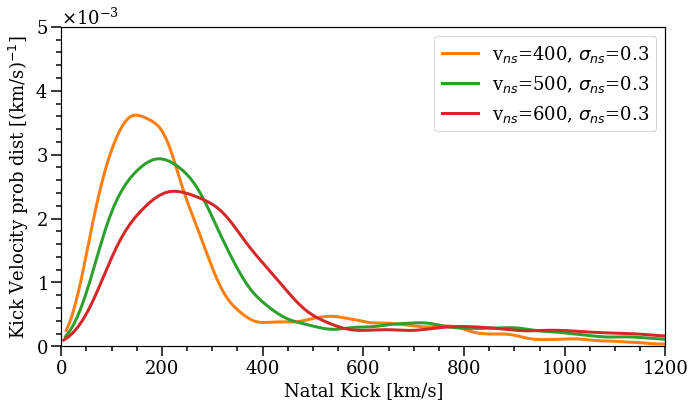

In [54]:
output=None

f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
ax._get_lines.get_next_color()
ax.set_ylim(0, 5e-3)
plot_kde(kick_models["SIGMA_0.3_RANGE"][::2], NS_KICKS_3D, NS_KICKS_2D, output=output) 


## Comparison with SSE

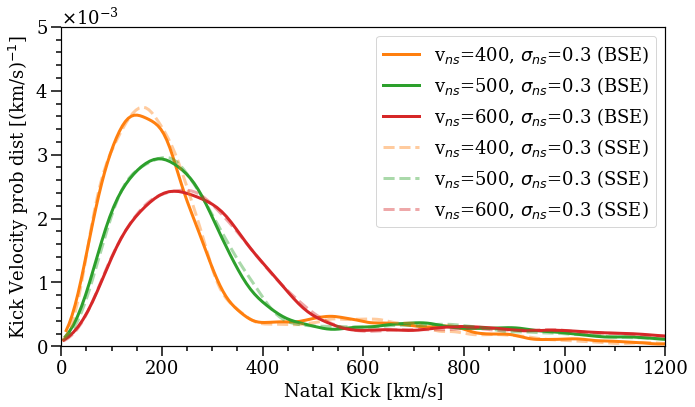

In [57]:
output='plots/sigma_0.3_range_bse.pdf'

f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
ax._get_lines.get_next_color()
ax.set_ylim(0, 5e-3)
plot_kde(kick_models["SIGMA_0.3_RANGE"][::2], NS_KICKS_3D, NS_KICKS_2D, label_suffix=' (BSE)', d=3)

plt.gca().set_prop_cycle(None)
ax._get_lines.get_next_color()
plot_kde(kick_models["SIGMA_0.3_RANGE"][::2], NS_KICKS_3D_SSE, NS_KICKS_2D_SSE, d=3, linestyle='--', label_suffix=' (SSE)', alpha=0.4)

# plt.savefig(output)

In [56]:
from cycler import cycler
import matplotlib.colors as mcolors

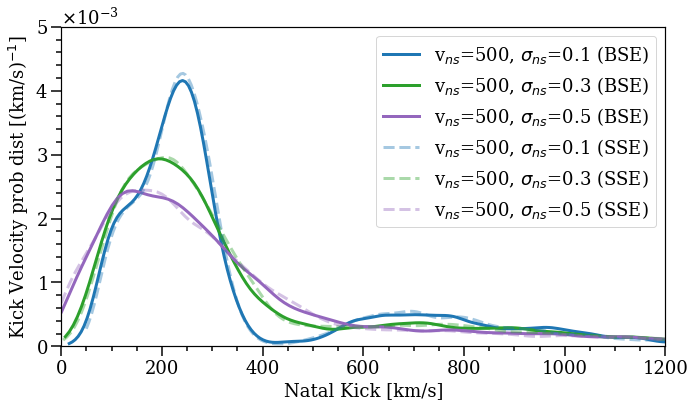

In [58]:
output='plots/ns_kicks_500_range_bse.pdf'

f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
ax.set_ylim(0, 5e-3)
ax.set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C0', 'C2', 'C4'])))
plot_kde(kick_models["NS_500_RANGE"][::2], NS_KICKS_3D, NS_KICKS_2D, label_suffix=' (BSE)')

ax.set_prop_cycle(cycler(color=mcolors.to_rgba_array(['C0', 'C2', 'C4'])))
plot_kde(kick_models["NS_500_RANGE"][::2], NS_KICKS_3D_SSE, NS_KICKS_2D_SSE, linestyle='--', label_suffix=' (SSE)', alpha=0.4)

# plt.savefig(output)


# Read Likelihood Data

In [6]:
p_models = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods_bse/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)

# normalize and reshape the array
p_models = p_models/np.max(p_models)

p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
print(np.array2string(p_models_2d, formatter={'float_kind': '{0:.3f}'.format}))

[[0.001 0.007 0.015 0.008 0.003]
 [0.009 0.088 0.162 0.098 0.022]
 [0.027 0.228 0.521 0.335 0.084]
 [0.061 0.417 1.000 0.427 0.073]
 [0.034 0.288 0.683 0.302 0.040]
 [0.009 0.075 0.190 0.127 0.015]]


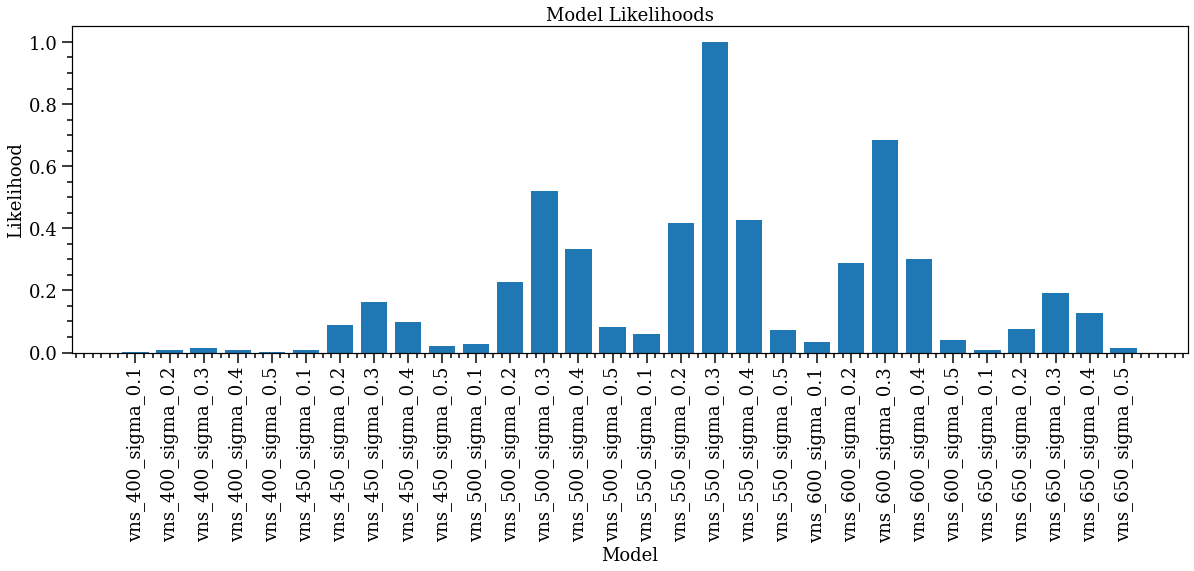

In [7]:
f, ax= plt.subplots(1, 1,  figsize=(20,6)) 

x_range = np.linspace(0, len(p_models), len(p_models))
plt.bar(x_range, p_models, tick_label=columns)

layoutAxes(ax=ax, nameX='Model',\
           nameY='Likelihood')
plt.xticks(rotation=90)
# plt.semilogy()

plt.title("Model Likelihoods", fontsize=18)

plt.show()

## 2D Plot

In [8]:
p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
max_num = len(p_models) # number of max likelihoods to label

# Some code to generate labels for only the top n models
M = sorted(zip(p_models), reverse=True)[max_num - 1][0]
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels = label_f(p_models_2d)

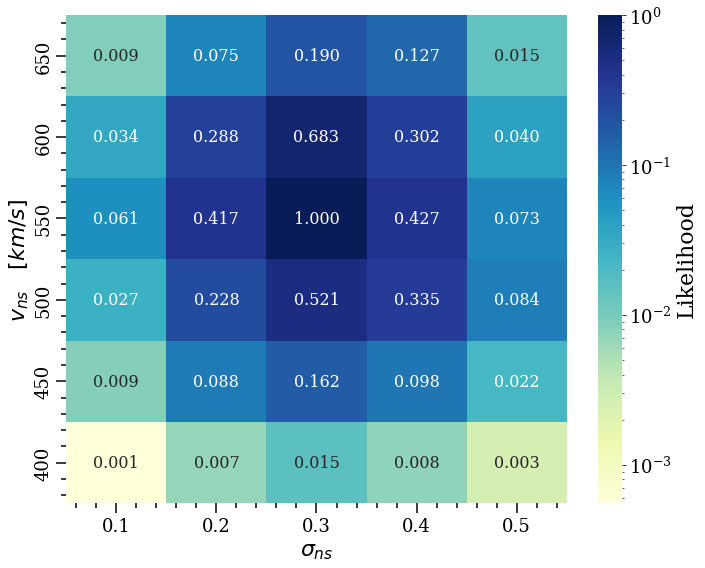

In [9]:
f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

ax = sns.heatmap(p_models_2d, cmap="YlGnBu", linewidth=0, norm=LogNorm(), xticklabels=sigmas, yticklabels=ns_kicks, \
                annot=labels, annot_kws={'fontsize':16}, fmt='', cbar_kws={'label': 'Likelihood'})
layoutAxes(ax=ax, fontsize=18)

plt.xlabel('$\sigma_{ns}$', fontsize=22)
plt.ylabel('$v_{ns} \quad [km/s]$', fontsize=22)

ax.figure.axes[-1].yaxis.label.set_size(22)
ax.figure.axes[-1].tick_params(labelsize=18)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 1 sigma, 2 sigma plot

In [10]:
def twoD_Gaussian(coords, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x = coords[0]
    y = coords[1]
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [11]:
# Create x and y indices
x = sigmas
y = ns_kicks
x, y = np.meshgrid(x, y)

#create data
data = p_models

In [12]:
from scipy import optimize as opt

# try to fit the data using a 2d gaussian
initial_guess = (1,0.3,550,0.05,10,0)

popt, pcov = opt.curve_fit(twoD_Gaussian, [x, y], data, p0=initial_guess)

X_mu_fit = popt[1]
Y_mu_fit = popt[2]

X_sigma_fit = popt[3]
Y_sigma_fit = popt[4]

theta_fit = popt[5]

In [13]:
print(f"Best fit v_ns mu: {Y_mu_fit}")
print(f"Best fit v_ns std: {Y_sigma_fit}")
print(f"Best fit sigma mu: {X_mu_fit}")
print(f"Best fit sigma std: {X_sigma_fit}")

Best fit v_ns mu: 554.6339857257647
Best fit v_ns std: 53.66531247551077
Best fit sigma mu: 0.30401686895817515
Best fit sigma std: 0.08037002916210145


In [14]:
import math
 
# Function to check if the point (x,y) is within ellipse centered at (h,k) with semi-maj axes (a,b), 
# rotated by angle
def check_point(x, y, h, k, a, b, angle):

    cos_angle = np.cos(np.radians(180.-angle))
    sin_angle = np.sin(np.radians(180.-angle))

    xc = x - h
    yc = y - k

    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle 

    rad_cc = (xct**2/(a)**2) + (yct**2/(b)**2)
 
    return rad_cc <= 1

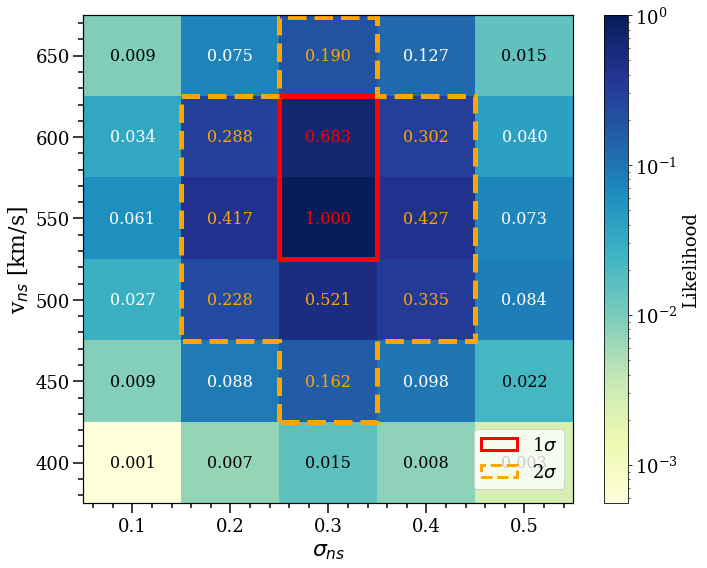

In [50]:
fig, ax = plt.subplots(1, 1,  figsize=(10,8)) 

dX = 0.05
dY = 25


# PLOT LIKELIHOOD GRID
im = plt.imshow(data.reshape(len(ns_kicks), len(sigmas)), aspect='auto', cmap=cm.YlGnBu, interpolation=None , \
           extent=[min(sigmas)-dX, max(sigmas)+dX, max(ns_kicks)+dY, min(ns_kicks)-dY], norm=LogNorm(vmin=min(p_models), vmax=max(p_models)))
cbar = plt.colorbar(label="Likelihood")




# PLOT LABELS
valfmt = matplotlib.ticker.StrMethodFormatter("{x:.3f}")
textcolors = ["black", "white"]
threshold = im.norm(p_models_2d.max())/2.

for i, kick in enumerate(ns_kicks):
    for j, sig in enumerate (sigmas):
        
        # black or white color based on cell lightness
        color=textcolors[int(im.norm(p_models_2d[i, j]) > threshold)]
        
        # 2 sigma models
        if check_point(sig, kick, X_mu_fit, Y_mu_fit, 2*X_sigma_fit, 2*Y_sigma_fit, theta_fit):
            color='orange'
            
        # 1 sigma models
        if check_point(sig, kick, X_mu_fit, Y_mu_fit, X_sigma_fit, Y_sigma_fit, theta_fit):
            color='r'
       
        text = ax.text(sig, kick, valfmt(p_models_2d[i, j]),
                       ha="center", va="center", color=color, fontsize=fs, zorder=3)

# # PLOT CONTOURS
lw = 5
alpha=0.7

# # 1 sigma contour
# ax.add_patch(Ellipse((X_mu_fit, Y_mu_fit), width=2*X_sigma_fit, height=2*Y_sigma_fit, angle=theta_fit,
#                      color='r', linewidth=lw, linestyle='--', alpha=alpha, fill=False, zorder=2, label= '1$\sigma$'))

# # 2 sigma contour
# ax.add_patch(Ellipse((X_mu_fit, Y_mu_fit), width=2*2*X_sigma_fit, height=2*2*Y_sigma_fit, angle=theta_fit,
#                      color='orange', linewidth=lw, linestyle='--', alpha=alpha, fill=False, zorder=2, label= '2$\sigma$'))

ax.add_patch(Rectangle((0.25,525), 0.1, 100, fill=False, edgecolor='r', hatch='',  lw=lw, linestyle='-', clip_on=False, label= '1$\sigma$', zorder=0))

ax.add_patch(Polygon(((0.25, 425), (0.25, 475), (0.15, 475), \
                      (0.15, 625), (0.25, 625), \
                      (0.25, 674), (0.35, 674), \
                      (0.35, 625), (0.45, 625), \
                      (0.45, 475), (0.35, 475), (0.35, 425)), fill=False, edgecolor='orange', hatch='', lw=lw, linestyle='--', clip_on=False, label='2$\sigma$',zorder=1))



# # PLOT BEST-FIT POINT
# lww = 3
# cww = 'r'
# plt.axhline(y=Y_mu_fit, color=cww, alpha=alpha, linewidth=lww, linestyle='-')
# plt.axvline(x=X_mu_fit, color=cww, alpha=alpha, linewidth=lww, linestyle='-')



# HOUSEKEEPING
layoutAxes(ax=ax, fontsize=fm)

plt.xlabel('$\sigma_{ns}$', fontsize=fl)
plt.ylabel('v$_{ns}$ [km/s]', fontsize=fl)

ax.figure.axes[-1].yaxis.label.set_size(fm)
ax.figure.axes[-1].tick_params(labelsize=fm)

handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1,0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order])

leg = ax.legend(fontsize=fm, bbox_to_anchor=(1.0, 0.17))

# change the line width for the legend
for patch in leg.get_patches():
    patch.set_linewidth(3.0)
    patch.set_alpha(1.0)
    
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('plots/model_likelihoods_2d_bse.pdf') 

plt.show()

# Identify the 3 most likely models

In [11]:
M = sorted(zip(p_models), reverse=True)[:5]
MAX_INDICES = np.where(p_models==M)[1]


labels = []
for i in range(len(MAX_INDICES)):
    labels.append("v$_{ns}$=" + f"{NS_KICK_MULT[MAX_INDICES[i]]}" + ", $\sigma_{ns}$=" + f"{SIGMAS[MAX_INDICES[i]]}")

NameError: name 'NS_KICK_MULT' is not defined

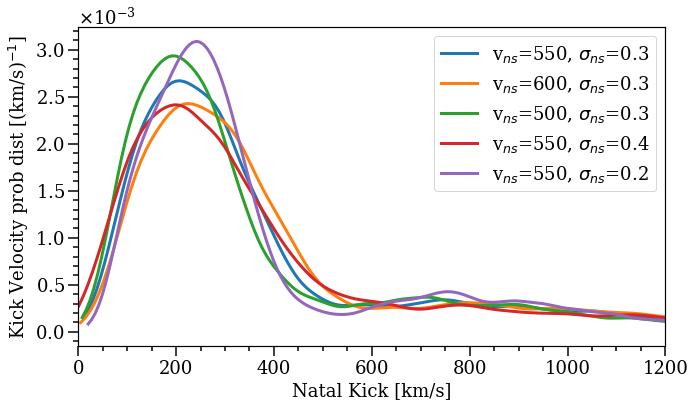

In [60]:
# The most likely models
f, ax= plt.subplots(1, 1,  figsize=(10,6))
plot_kde(MAX_INDICES, NS_KICKS_3D, NS_KICKS_2D, d=3)
plt.show()